In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rc
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

rc('font', family = 'AppleGothic')

In [71]:
data = pd.read_csv("oecd_family.csv")
#합계출산율(Total fertility rate) 추출
birth_rate = data.loc[(data.IND=='FAM1',['Country', 'Year','Value'])]

#2021년 이상 데이터 삭제
birth_rate = birth_rate.drop(birth_rate.loc[birth_rate.Year>=2021].index)

#2012년부터 2020년까지 출산율 결측치 없음
birth_rate.isna().sum()

#인덱스 재정렬
birth_rate.index = range(0,len(birth_rate))

#한글화를 위한 리스트 생성
CountryName = ["이스라엘","룩셈부르크","네덜란드","그리스","아이슬란드","라트비아","슬로베니아","프랑스","폴란드","튀르키예","스페인","벨기에","멕시코","아일랜드","스위스","핀란드","칠레","캐나다","대한민국","뉴질랜드","오스트레일리아","헝가리","미국","영국","오스트리아","스웨덴","덴마크","슬로바키아","체코","콜롬비아","일본","노르웨이","코스타리카","리투아니아","독일","에스토니아","포르투갈","이탈리아"]

#영어이름을 한글로
for i in range(0,38):
    for j in range(0,9):
        birth_rate.loc[i*9:i*9+j,"Country"] = CountryName[i]
        
birth_rate

,Country,Year,Value
0,이스라엘,2012,3.05
1,이스라엘,2013,3.03
2,이스라엘,2014,3.08
3,이스라엘,2015,3.09
4,이스라엘,2016,3.11
...,...,...,...
337,이탈리아,2016,1.36
338,이탈리아,2017,1.34
339,이탈리아,2018,1.31
340,이탈리아,2019,1.27


In [72]:
#경제활동인구(여자)중 경제활동 참가율 data
df2 = pd.read_csv("경제활동인구 및 참가율(OECD).csv", encoding= "euc-kr", skiprows = 1)
plt.rcParams['font.family'] = 'NanumGothicOTF'

#column(열) 이름 바꾸기 = 연도
    
df2= df2.rename(columns = {'여자 (%)' : '2012'})
for i in range(1,10):
    df2 = df2.rename(columns = {'여자 (%).{}'.format(i): str(2012+i)} )

namelist = []
#row(행) 이름 바꾸기. = 국가    
for i in range(len(df2)):
    x = df2.loc[i,'국가별'].find("(")
    name = df2.loc[i,'국가별']
    if(x != -1):
        name = name[:x]
        namelist.append(name)
        df2.rename(index = {i :name},inplace = True)
    else:
        df2.rename(index = {i :name},inplace = True)


#필요한 데이터만 추출.
col_name = []
for i in range(2012,2021):
    col_name.append(str(i))

rate_df = df2[col_name]

#NaN 값 제거.
rate_df.drop(rate_df.index[0], inplace= True)
rate_df.dropna(inplace=True)
rate_df.head()

#빈값 찾기.
col = rate_df.columns.values

index = rate_df.index.values
outlier = {}
for i in index:
    for c in col:
        if (rate_df.loc[i,str(c)] == '-'):
            outlier[c] = i

#국가별 평균값으로 빈값 찾기.
sum = 0
for key in outlier.keys():
    sum = 0
    for c in col:
        if (c == key):
            continue
        else:
            sum += float(rate_df.loc[outlier.get(key),str(c)])
    rate_df.loc[outlier.get(key), key] = round(sum/(len(col)-len(outlier)),1)

country = []
year = []
value = []
rate_val = []

#새로운 데이터 만들기 위한 값 배치.
for i in range(len(namelist)):
    for j in range(2012,2021):
        country.append(namelist[i])
        year.append(j)

for i in range(len(country)):
    rate_val.append(float(rate_df[str(year[i])][country[i]]))

# 전처리 완료한 데이터.
rate_df = pd.DataFrame({
    'Country' : country,
    'Year' : year,
    'rate_val' : rate_val
})

C:\anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\anaconda\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_s

In [73]:
#gdp 데이터
df = pd.read_csv("OECD 국가의 주요지표.csv", encoding= "euc-kr", skiprows = 1)

#column(열) 이름 바꾸기 = 연도
df= df.rename(columns = {'국내총생산(GDP)(당해년 가격) (10억US$)' : '2012'})

for i in range(1,10):
    df = df.rename(columns = {'국내총생산(GDP)(당해년 가격) (10억US$).{}'.format(i): str(2012+i)} )

#row(행) 이름 바꾸기. = 국가
for i in range(len(df)):
    df.rename(index = {i :df.loc[i,'국가별']},inplace = True)

#필요한 GDP 데이터만 데이터프레임으로 추출.
#column 이름으로 추출.
col_name = []
for i in range(2012,2021):
    col_name.append(str(i))

GDP_df = df[col_name]

#NaN 값 제거.
GDP_df.drop(GDP_df.index[0], inplace= True)
GDP_df.dropna(inplace=True)

#OECD 총값 제거.
GDP_df.drop(GDP_df.tail(1).index,inplace=True)
#빈값, 잘못된 값 찾기
col = GDP_df.columns.values

index = GDP_df.index.values
outlier = {}
for i in index:
    for c in col:
        if (GDP_df.loc[i,str(c)] == '-'):
            outlier[c] = i
#빈값, 잘못된 값을 각 국의 평균값으로 대체.
sum = 0
for key in outlier.keys():
    sum = 0
    for c in col:
        if (c == key):
            continue
        else:
            sum += float(GDP_df.loc[outlier.get(key),str(c)])
    GDP_df.loc[outlier.get(key), key] = round(sum/(len(col)-len(outlier)),1)

country = []
year = []
value = []
gdp_val = []

#새로운 데이터 만들기 위한 값 배치.
for i in range(len(namelist)):
    for j in range(2012,2021):
        country.append(namelist[i])
        year.append(j)

for i in range(len(country)):
    gdp_val.append(float(GDP_df[str(year[i])][country[i]]))
    
#전처리 완료한 데이터.
gdp_df = pd.DataFrame({
    'Country' : country,
    'Year' : year,
    'gdp_val' : gdp_val
})

gdp_df

C:\anaconda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\anaconda\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,Country,Year,gdp_val
0,대한민국,2012,1278.0
1,대한민국,2013,1370.6
2,대한민국,2014,1484.0
3,대한민국,2015,1465.3
4,대한민국,2016,1500.0
...,...,...,...
337,뉴질랜드,2016,188.9
338,뉴질랜드,2017,207.0
339,뉴질랜드,2018,212.2
340,뉴질랜드,2019,209.1


In [74]:
#성불평등지수
inequality = pd.read_csv("sex_inequality.csv")
inequality = inequality.set_index('국가별')
inequality = inequality.drop(['대륙'], axis=1)

country = []
year = []
value = []
inequality_val = []

#새로운 데이터 만들기 위한 값 배치.
for i in range(len(namelist)):
    for j in range(2012,2021):
        country.append(namelist[i])
        year.append(j)

for i in range(len(country)):
    inequality_val.append(float(inequality[str(year[i])][country[i]]))

# 전처리 완료한 데이터.
inequality = pd.DataFrame({
    'Country' : country,
    'Year' : year,
    'inequality_val' : inequality_val
})
inequality

,Country,Year,inequality_val
0,대한민국,2012,0.108
1,대한민국,2013,0.108
2,대한민국,2014,0.100
3,대한민국,2015,0.096
4,대한민국,2016,0.086
...,...,...,...
337,뉴질랜드,2016,0.126
338,뉴질랜드,2017,0.112
339,뉴질랜드,2018,0.102
340,뉴질랜드,2019,0.100


In [75]:
totaldf = pd.merge(birth_rate, rate_df, on = ['Country','Year'])
totaldf = pd.merge(totaldf, gdp_df, on = ['Country','Year'])
totaldf = pd.merge(totaldf, inequality, on = ['Country','Year'])
totaldf_copy = totaldf.copy()

In [76]:
def outlier_iqr(data, column): 
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR =',round(iqr, 5))     
    print('lower =', round(lower,5))     
    print('upper =', round(upper,5))    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 인덱스 각각 저장하기     
    data1 = data[data[column] > upper].index     
    data2 = data[data[column] < lower].index
    
    data.drop(data1, inplace = True)
    data.drop(data2, inplace = True)
    
    # 이상치 총 개수 구하기
    print("미만인 데이터",data1.shape[0])
    print("초과인 데이터",data2.shape[0])
    print()
    return data

In [77]:
outlier_iqr(totaldf, 'inequality_val')
outlier_iqr(totaldf, 'rate_val')
outlier_iqr(totaldf, 'Value')
outlier_iqr(totaldf, 'gdp_val')
totaldf

IQR = 0.0845
lower = -0.0585
upper = 0.2795
미만인 데이터 35
초과인 데이터 0

IQR = 7.0
lower = 41.1
upper = 69.1
미만인 데이터 15
초과인 데이터 9

IQR = 0.285
lower = 1.0125
upper = 2.1525
미만인 데이터 9
초과인 데이터 3

IQR = 1181.55
lower = -1583.875
upper = 3142.325
미만인 데이터 27
초과인 데이터 0



,Country,Year,Value,rate_val,gdp_val,inequality_val
9,룩셈부르크,2012,1.57,51.9,56.7,0.093
10,룩셈부르크,2013,1.55,52.5,61.7,0.072
11,룩셈부르크,2014,1.50,53.4,66.1,0.071
12,룩셈부르크,2015,1.47,54.6,57.7,0.067
13,룩셈부르크,2016,1.41,53.5,60.7,0.063
...,...,...,...,...,...,...
330,포르투갈,2018,1.41,54.5,242.2,0.074
331,포르투갈,2019,1.42,54.8,239.5,0.071
332,포르투갈,2020,1.40,53.6,231.3,0.069
339,이탈리아,2018,1.31,41.1,2091.1,0.057


Text(0.5, 1.0, 'GDP 제거 후')

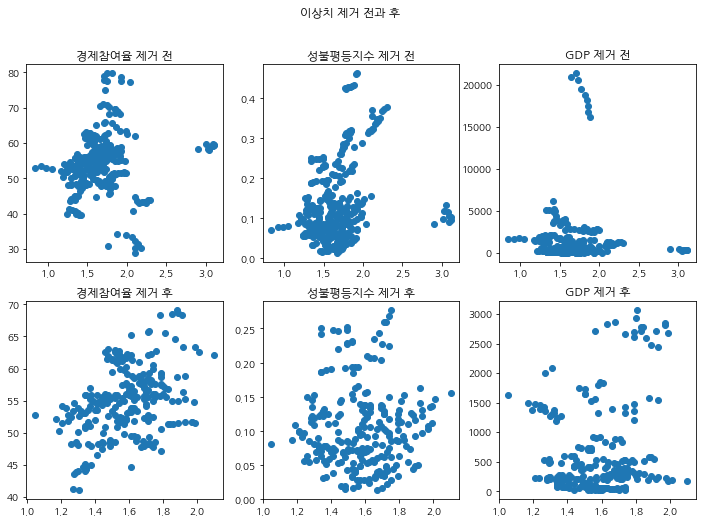

In [78]:
plt.figure(figsize=(12,8))
plt.suptitle("이상치 제거 전과 후")

plt.subplot(2,3,1)
plt.scatter(totaldf_copy['Value'], totaldf_copy['rate_val'])
plt.title("경제참여율 제거 전")
plt.subplot(2,3,4)
plt.scatter(totaldf['Value'], totaldf['rate_val'])
plt.title("경제참여율 제거 후")

plt.subplot(2,3,2)
plt.scatter(totaldf_copy['Value'], totaldf_copy['inequality_val'])
plt.title("성불평등지수 제거 전")
plt.subplot(2,3,5)
plt.scatter(totaldf['Value'], totaldf['inequality_val'])
plt.title("성불평등지수 제거 후")

plt.subplot(2,3,3)
plt.scatter(totaldf_copy['Value'], totaldf_copy['gdp_val'])
plt.title("GDP 제거 전")
plt.subplot(2,3,6)
plt.scatter(totaldf['Value'], totaldf['gdp_val'])
plt.title("GDP 제거 후")

Text(0.5, 1.0, 'GDP')

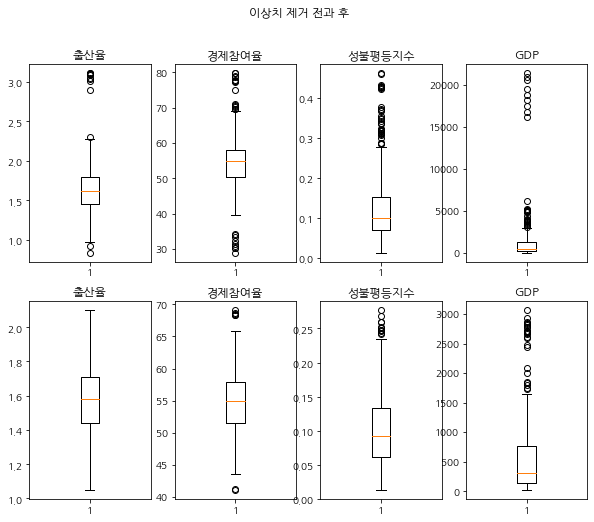

In [79]:
plt.figure(figsize=(10,8))
plt.suptitle("이상치 제거 전과 후")
plt.subplot(2,4,1)
plt.boxplot(totaldf_copy.Value)
plt.title("출산율")
plt.subplot(2,4,2)
plt.boxplot(totaldf_copy.rate_val)
plt.title("경제참여율")
plt.subplot(2,4,3)
plt.boxplot(totaldf_copy.inequality_val)
plt.title("성불평등지수")
plt.subplot(2,4,4)
plt.boxplot(totaldf_copy.gdp_val)
plt.title("GDP")

plt.subplot(2,4,5)
plt.boxplot(totaldf.Value)
plt.title("출산율")
plt.subplot(2,4,6)
plt.boxplot(totaldf.rate_val)
plt.title("경제참여율")
plt.subplot(2,4,7)
plt.boxplot(totaldf.inequality_val)
plt.title("성불평등지수")
plt.subplot(2,4,8)
plt.boxplot(totaldf.gdp_val)
plt.title("GDP")

In [80]:
print("정규성 검정")
print("H0 정규 분포를 따른다  H1 정규 분포를 따르지 않는다")
print()
print("이상치 제거 전 정규성 검정")
print("출산율\t\t",stats.shapiro(totaldf_copy.Value))
print("여성겸제참여율\t",stats.shapiro(totaldf_copy.rate_val))
print("GDP\t\t",stats.shapiro(totaldf_copy.gdp_val))
print("성불평등지수\t",stats.shapiro(totaldf_copy.inequality_val))
print()
print("이상치 제거 후 정규성 검정")
print("출산율\t\t",stats.shapiro(totaldf.Value))
print("여성경제참여율\t",stats.shapiro(totaldf.rate_val))
print("GDP\t\t",stats.shapiro(totaldf.gdp_val))
print("성불평등지수\t",stats.shapiro(totaldf.inequality_val))

정규성 검정
H0 정규 분포를 따른다  H1 정규 분포를 따르지 않는다

이상치 제거 전 정규성 검정
출산율		 ShapiroResult(statistic=0.8447140455245972, pvalue=6.7140856521597105e-18)
여성겸제참여율	 ShapiroResult(statistic=0.9562874436378479, pvalue=1.4637301148923143e-08)
GDP		 ShapiroResult(statistic=0.39027631282806396, pvalue=2.765436859144217e-32)
성불평등지수	 ShapiroResult(statistic=0.8431843519210815, pvalue=5.493497940276463e-18)

이상치 제거 후 정규성 검정
출산율		 ShapiroResult(statistic=0.9935651421546936, pvalue=0.3785301744937897)
여성경제참여율	 ShapiroResult(statistic=0.9918838143348694, pvalue=0.19800779223442078)
GDP		 ShapiroResult(statistic=0.7503794431686401, pvalue=6.236011757448589e-19)
성불평등지수	 ShapiroResult(statistic=0.9321660399436951, pvalue=3.675125981317251e-09)


In [81]:
print("출산율과 요인의 pearson검정")
print("H0 두 변수가 관계가 없다  H1 두 변수가 관계가 있다")
print()
print("출산율과 경제참여율")
x = totaldf_copy['Value']
y = totaldf_copy['rate_val']
r, p = stats.pearsonr(x,y)
print(("이상치 제거 전 상관계수 : %.5f p-value : %f")%(r,p))
x = totaldf['Value']
y = totaldf['rate_val']
r, p = stats.pearsonr(x,y)
print(("이상치 제거 후 상관계수 : %.5f p-value : %f")%(r,p))
print()
print("출산율과 성불평등지수")
x = totaldf_copy['Value']
y = totaldf_copy['inequality_val']
r, p = stats.pearsonr(x,y)
print(("이상치 제거 전 상관계수 : %.5f p-value : %f")%(r,p))
x = totaldf['Value']
y = totaldf['inequality_val']
r, p = stats.pearsonr(x,y)
print(("이상치 제거 후 상관계수 : %.5f p-value : %f")%(r,p))
print()
print("출산율과 GDP")
x = totaldf_copy['Value']
y = totaldf_copy['gdp_val']
r, p = stats.pearsonr(x,y)
print(("이상치 제거 전 상관계수 : %.5f p-value : %f")%(r,p))
x = totaldf['Value']
y = totaldf['gdp_val']
r, p = stats.pearsonr(x,y)
print(("이상치 제거 후 상관계수 : %.5f p-value : %f")%(r,p))

출산율과 요인의 pearson검정
H0 두 변수가 관계가 없다  H1 두 변수가 관계가 있다

출산율과 경제참여율
이상치 제거 전 상관계수 : 0.12363 p-value : 0.022206
이상치 제거 후 상관계수 : 0.42379 p-value : 0.000000

출산율과 성불평등지수
이상치 제거 전 상관계수 : 0.27962 p-value : 0.000000
이상치 제거 후 상관계수 : 0.00032 p-value : 0.995972

출산율과 GDP
이상치 제거 전 상관계수 : 0.01426 p-value : 0.792802
이상치 제거 후 상관계수 : 0.17620 p-value : 0.005785


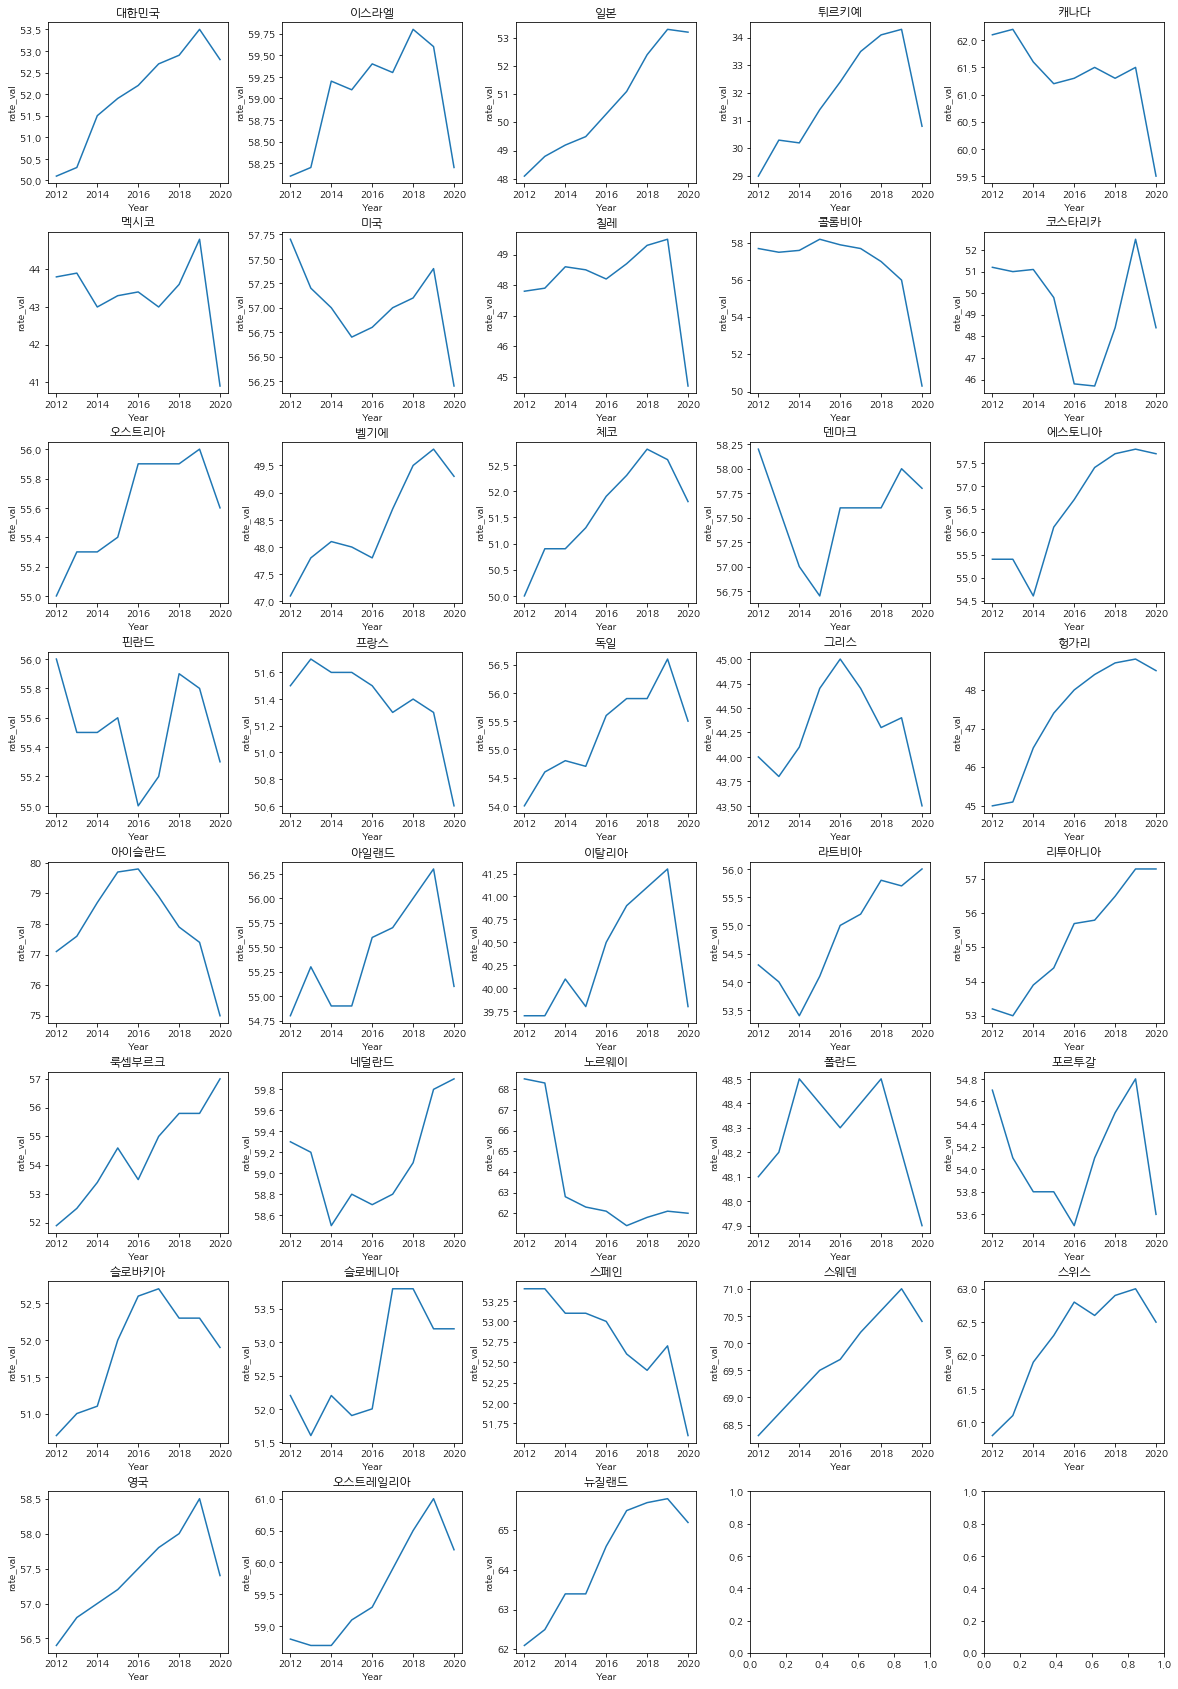

In [82]:
#데이터 시각화 출산율-경제참여율
fig, ax = plt.subplots(ncols = 5, nrows = 8)
fig.set_size_inches((20,30))
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)
try:
    i = 0
    for x in range(8):
        for y in range(5):
            d = totaldf_copy[totaldf_copy['Country'] == namelist[i]]
            sns.lineplot(x = 'Year', y = 'rate_val', data = d, ax = ax[x,y])
            ax[x,y].set_title(namelist[i])
            i = i+1
except:
    print()

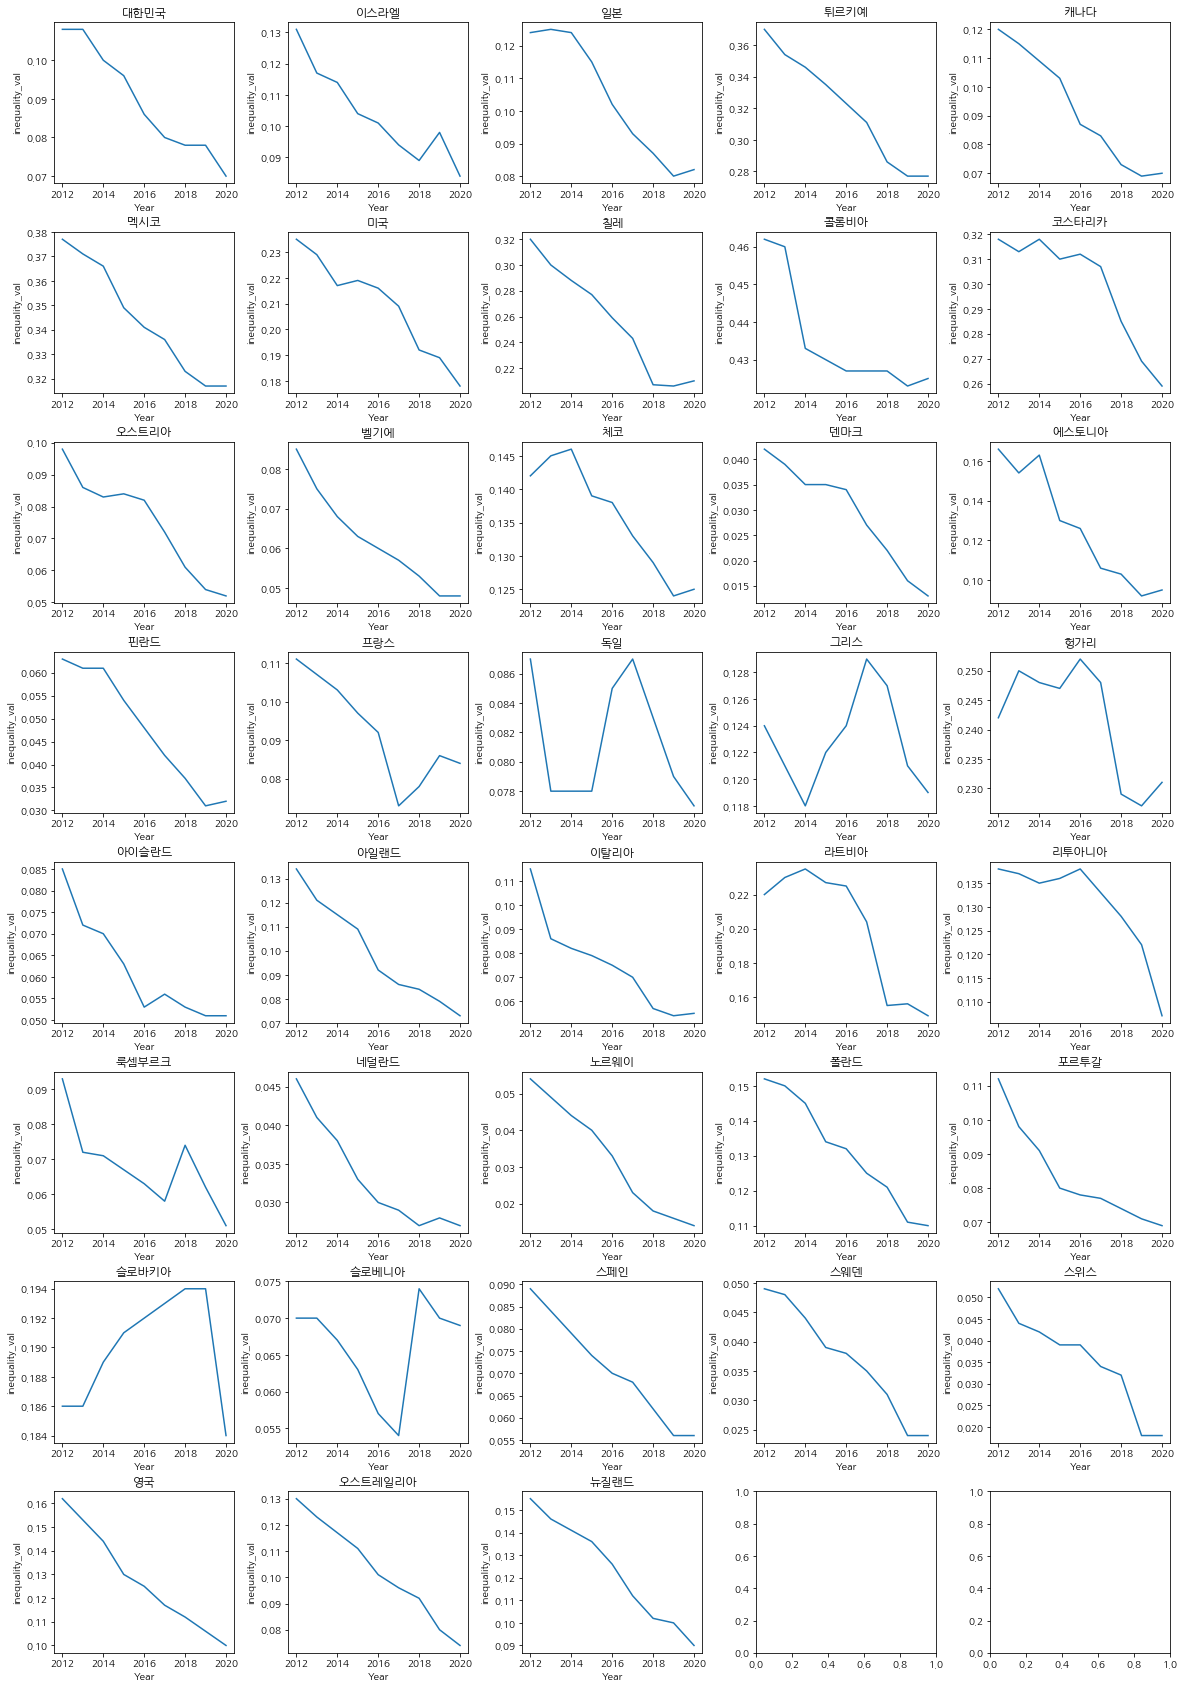

In [83]:
#데이터 시각화 출산율-성불평등지수
fig, ax = plt.subplots(ncols = 5, nrows = 8)
fig.set_size_inches((20,30))
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)
try:
    i = 0
    for x in range(8):
        for y in range(5):
            d = totaldf_copy[totaldf_copy['Country'] == namelist[i]]
            sns.lineplot(x = 'Year', y = 'inequality_val', data = d, ax = ax[x,y])
            ax[x,y].set_title(namelist[i])
            i = i+1
except:
    print()

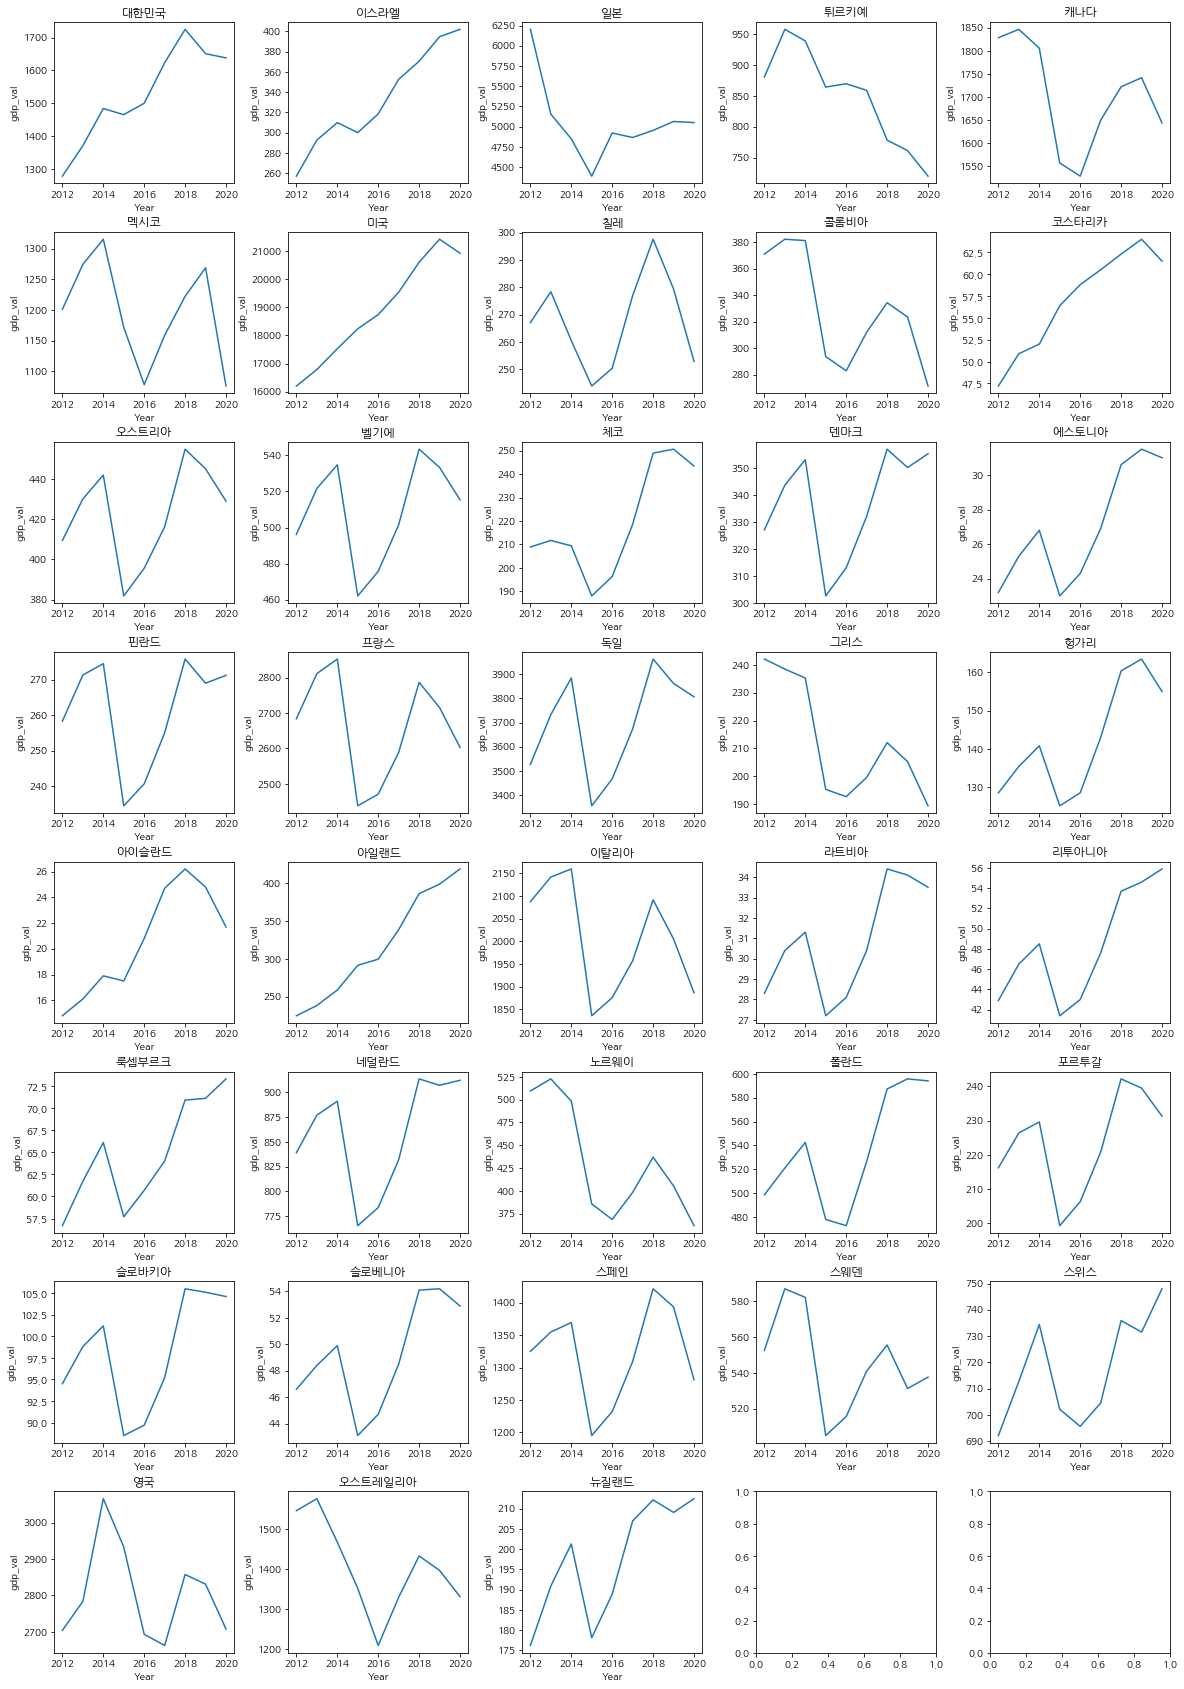

In [84]:
#데이터 시각화 출산율-GDP
fig, ax = plt.subplots(ncols = 5, nrows = 8)
fig.set_size_inches((20,30))
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)
try:
    i = 0
    for x in range(8):
        for y in range(5):
            d = totaldf_copy[totaldf_copy['Country'] == namelist[i]]
            sns.lineplot(x = 'Year', y = 'gdp_val', data = d, ax = ax[x,y])
            ax[x,y].set_title(namelist[i])
            i = i+1
except:
    print()

[0.01512162]
[0.75138789]


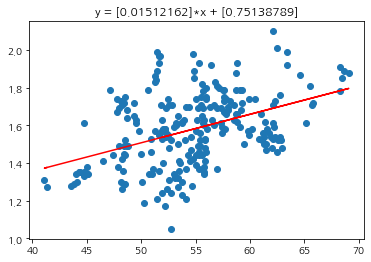

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     52.98
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           4.69e-12
Time:                        18:47:13   Log-Likelihood:                 80.493
No. Observations:                 244   AIC:                            -157.0
Df Residuals:                     242   BIC:                            -150.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7514      0.114      6.572      0.000       0.526       0.977
x1             0.0151      0.002      7.279      0.000       0.011       0.019
==============================================================================
Omnibus:                        2.443   Durbin-Watson:                   0.453
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                2.517
Skew:                           0.230   Prob(JB):                        0.284
Kurtosis:                       2.808   Cond. No.                         563.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
lr = LinearRegression()
y = (totaldf.Value.values).reshape(-1,1)
x = (totaldf.rate_val.values).reshape(-1,1)
lr.fit(x,y)
print(lr.coef_[0]) #기울기, 무게 또는 계수
print(lr.intercept_) #y축 절편
Y2 = lr.coef_[0]*x +lr.intercept_
plt.scatter(x,y)
plt.plot(x, Y2, color='red')
plt.title('y = {}*x + {}'.format(lr.coef_[0], lr.intercept_))
plt.show()
#value = 0.015 * rate_val + 0.75
results = sm.OLS(y, sm.add_constant(x)).fit()
results.summary()
#F-statistic = 4.69e-12로 회귀 분석 모델 전체에 대해 통계적으로 의미가 있음.
#변수 x1 = 0.000으로 표기. 0.05보다 작으므로 Value를 설명하는데에 유의하다고 판단할 수 있음.
#R-squared  = 0.18로 예측값을 믿을 수 없음. (1에 가까울수록 신뢰도 있음)

[4.45558935e-05]
[1.55103119]


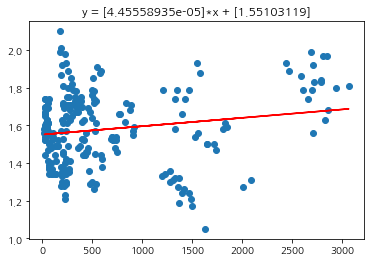

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     7.754
Date:                Thu, 15 Dec 2022   Prob (F-statistic):            0.00578
Time:                        18:47:13   Log-Likelihood:                 60.189
No. Observations:                 244   AIC:                            -116.4
Df Residuals:                     242   BIC:                            -109.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5510      0.016     97.470      0.000       1.520       1.582
x1          4.456e-05    1.6e-05      2.785      0.006     1.3e-05    7.61e-05
==============================================================================
Omnibus:                        0.928   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                1.041
Skew:                          -0.128   Prob(JB):                        0.594
Kurtosis:                       2.808   Cond. No.                     1.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
lr = LinearRegression()
y = (totaldf.Value.values).reshape(-1,1)
x = (totaldf.gdp_val.values).reshape(-1,1)
lr.fit(x,y)
print(lr.coef_[0]) #기울기, 무게 또는 계수
print(lr.intercept_) #y축 절편
Y2 = lr.coef_[0]*x +lr.intercept_
plt.scatter(x,y)
plt.plot(x, Y2, color='red')
plt.title('y = {}*x + {}'.format(lr.coef_[0], lr.intercept_))
plt.show()
results = sm.OLS(y, sm.add_constant(x)).fit()
results.summary()
#F-statistic = 0.00578로 회귀 분석 모델 전체에 대해 통계적으로 의미가 있음.
#변수 x1  = 0.006으로 표기. 0.05보다 작으므로 Value를 설명하는데에 유의하다고 판단할 수 있음.
#R-squared  = 0.031로 31%의 정확도를 가짐.(1에 가까울수록 신뢰도 있음)

[0.00105044]
[1.57952173]


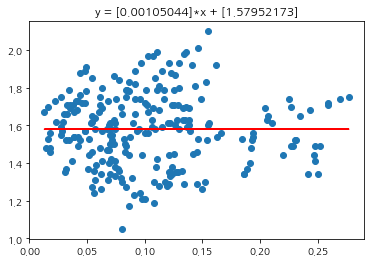

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                 2.554e-05
Date:                Thu, 15 Dec 2022   Prob (F-statistic):              0.996
Time:                        18:47:13   Log-Likelihood:                 56.341
No. Observations:                 244   AIC:                            -108.7
Df Residuals:                     242   BIC:                            -101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5795      0.025     63.373      0.000       1.530       1.629
x1             0.0011      0.208      0.005      0.996      -0.408       0.411
==============================================================================
Omnibus:                        2.526   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                1.939
Skew:                           0.036   Prob(JB):                        0.379
Kurtosis:                       2.569   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
lr = LinearRegression()
y = (totaldf.Value.values).reshape(-1,1)
x = (totaldf.inequality_val.values).reshape(-1,1)
lr.fit(x,y)
print(lr.coef_[0]) #기울기, 무게 또는 계수
print(lr.intercept_) #y축 절편
Y2 = lr.coef_[0]*x +lr.intercept_
plt.scatter(x,y)
plt.plot(x, Y2, color='red')
plt.title('y = {}*x + {}'.format(lr.coef_[0], lr.intercept_))
plt.show()
results = sm.OLS(y, sm.add_constant(x)).fit()
results.summary()
#F-statistic = 2.554e-05로 회귀 분석 모델 전체에 대해 통계적으로 의미가 있음.
#변수 x1  = 0.996으로 표기. 0.05보다 크기에 Value를 설명하는데에 유의하지 않음.
#R-squared  = -0.004로 예측값을 믿을 수 없음. (1에 가까울수록 신뢰도 있음)

In [88]:
#3가지 변수 다 넣은 경우
lr = LinearRegression()
x = totaldf.loc[:,['rate_val','gdp_val', 'inequality_val']].values
y = (totaldf.Value.values).reshape(-1,1)
lr.fit(x,y)
print(lr.coef_[0]) #기울기, 무게 또는 계수
print(lr.intercept_) #y축 절편
Y2 = lr.coef_[0]*x +lr.intercept_
# value = 0.015 * rate_val + 0.75
results = sm.OLS(y, sm.add_constant(x)).fit()
results.summary()
#F-statistic = 9.81e-15로 회귀 분석 모델 전체에 대해 통계적으로 의미가 있음.
#p-val는 모든 변수에서 0.05보다 미만이기에 Value를 설명하는데에 유의미하다.
#R-squared  = 약0.24 로 24%의 설명력을 가진다고 판단할 수 있음.

[1.83348729e-02 4.22327796e-05 8.07360676e-01]
[0.46418776]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     26.28
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           9.81e-15
Time:                        18:47:13   Log-Likelihood:                 90.996
No. Observations:                 244   AIC:                            -174.0
Df Residuals:                     240   BIC:                            -160.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4642      0.132      3.511      0.001       0.204       0.725
x1             0.0183      0.002      8.284      0.000       0.014       0.023
x2          4.223e-05   1.44e-05      2.936      0.004    1.39e-05    7.06e-05
x3             0.8074      0.203      3.985      0.000       0.408       1.206
==============================================================================
Omnibus:                        1.072   Durbin-Watson:                   0.422
Prob(Omnibus):                  0.585   Jarque-Bera (JB):                1.120
Skew:                           0.081   Prob(JB):                        0.571
Kurtosis:                       2.710   Cond. No.                     2.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""